In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.svm import SVC


#from textblob import TextBlob, Word

In [2]:
# import cleaned comments data from csv
df = pd.read_csv('comments_clean.csv')
df.head()

,body,length,word_count,target
0,typically hosting centralized service and mere...,186,30,1
1,yup feast for,25,6,1
2,4000 you kidding right the floor bored ape lik...,68,13,1
3,prognosis negative someone dropped fucking jun...,72,11,1
4,nano but for monkey,22,4,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   body        3232 non-null   object
 1   length      3232 non-null   int64 
 2   word_count  3232 non-null   int64 
 3   target      3232 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 101.1+ KB


In [4]:
df.isna().sum()

body          0
length        0
word_count    0
target        0
dtype: int64

## set up X and y, train/test split

In [5]:
X = df['body']
y = df['target']

y.value_counts(normalize=True) # baseline accuracy



1    0.541151
0    0.458849
Name: target, dtype: float64

In [6]:
# train/test split
# stratify y just in case, even though the classes are balanced
# test_size : default = 0.25
# shuffle: default = True

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y, #to keep the same balance of y in the test and train data
                                                    random_state=42)

In [7]:
import sys
sys.getsizeof(X_train)  # size of X_train

504297

In [8]:
X_train.shape

(2424,)

In [9]:
X_test.shape

(808,)

In [10]:
y_train.shape

(2424,)

In [11]:
y_test.shape

(808,)

## Model 1: TFIDF and Random Forest Classifer

In [12]:
pipe = Pipeline([
                ('tf', TfidfVectorizer()),
                ('rf', RandomForestClassifier())
])

params = {
                'tf__max_features' : [5000,10_000,15_000],
                'tf__ngram_range' : [(1,1), (1,2)]
}


gs = GridSearchCV(pipe, param_grid = params, cv = 5)

In [13]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'tf__max_features': [5000, 10000, 15000],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [14]:
print(gs.best_params_)
gs_model = gs.best_estimator_

gs_train_accuracy = round(gs_model.score(X_train, y_train),2)
print(f'Train Accuracy: {gs_train_accuracy}')

gs_test_accuracy = round(gs_model.score(X_test, y_test),2)
print(f'Test Accuracy: {gs_test_accuracy}')

{'tf__max_features': 10000, 'tf__ngram_range': (1, 2)}
Train Accuracy: 0.99
Test Accuracy: 0.7


In [15]:
y_pred = gs.predict(X_test)
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,224,147
actual pos,97,340


## Model 2: TFIDF and Extra Trees Classifer

In [16]:
pipe = Pipeline([
                ('tf', TfidfVectorizer()),
                ('et', ExtraTreesClassifier())
])

params = {
                'tf__max_features' : [5000,10_000,15_000],
                'tf__ngram_range' : [(1,1), (1,2)]
}


gs = GridSearchCV(pipe, param_grid = params, cv = 5)

In [17]:
gs.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('et', ExtraTreesClassifier())]),
             param_grid={'tf__max_features': [5000, 10000, 15000],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [18]:
print(gs.best_params_)
gs_model = gs.best_estimator_

gs_train_accuracy = round(gs_model.score(X_train, y_train),2)
print(f'Train Accuracy: {gs_train_accuracy}')

gs_test_accuracy = round(gs_model.score(X_test, y_test),2)
print(f'Test Accuracy: {gs_test_accuracy}')

{'tf__max_features': 5000, 'tf__ngram_range': (1, 1)}
Train Accuracy: 1.0
Test Accuracy: 0.71


In [19]:
y_pred = gs.predict(X_test)
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,245,126
actual pos,107,330


## Model 3: TFIDF and Support Vector Machine Classifier

In [20]:
pipe = Pipeline([
                ('tf', TfidfVectorizer()),
                ('svc', SVC())
])

params = {
                'tf__max_features' : [5000,10_000,15_000],
                'tf__ngram_range' : [(1,1), (1,2)]
}


gs = GridSearchCV(pipe, param_grid = params, cv = 5)

In [21]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('svc', SVC())]),
             param_grid={'tf__max_features': [5000, 10000, 15000],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [22]:
print(gs.best_params_)
gs_model = gs.best_estimator_

gs_train_accuracy = round(gs_model.score(X_train, y_train),2)
print(f'Train Accuracy: {gs_train_accuracy}')

gs_test_accuracy = round(gs_model.score(X_test, y_test),2)
print(f'Test Accuracy: {gs_test_accuracy}')

{'tf__max_features': 5000, 'tf__ngram_range': (1, 1)}
Train Accuracy: 0.98
Test Accuracy: 0.74


In [23]:
y_pred = gs.predict(X_test)
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,245,126
actual pos,83,354


## Model 4: TFIDF and ADA Boost Classifier

In [24]:
pipe = Pipeline([
                ('tf', TfidfVectorizer()),
                ('ada', AdaBoostClassifier())
])

params = {
                'tf__max_features' : [5000,10_000,15_000],
                'tf__ngram_range' : [(1,1), (1,2)]
}


gs = GridSearchCV(pipe, param_grid = params, cv = 5)

In [25]:
gs.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('ada', AdaBoostClassifier())]),
             param_grid={'tf__max_features': [5000, 10000, 15000],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [26]:
print(gs.best_params_)
gs_model = gs.best_estimator_

gs_train_accuracy = round(gs_model.score(X_train, y_train),2)
print(f'Train Accuracy: {gs_train_accuracy}')

gs_test_accuracy = round(gs_model.score(X_test, y_test),2)
print(f'Test Accuracy: {gs_test_accuracy}')

{'tf__max_features': 5000, 'tf__ngram_range': (1, 1)}
Train Accuracy: 0.71
Test Accuracy: 0.64


In [27]:
y_pred = gs.predict(X_test)
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,142,229
actual pos,63,374


## Model 5: TFIDF and Gradient Boost Classifier

In [28]:
pipe = Pipeline([
                ('tf', TfidfVectorizer()),
                ('gr', GradientBoostingClassifier())
])

params = {
                'tf__max_features' : [5000,10_000,15_000],
                'tf__ngram_range' : [(1,1), (1,2)]
}


gs = GridSearchCV(pipe, param_grid = params, cv = 5)

In [29]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('gr', GradientBoostingClassifier())]),
             param_grid={'tf__max_features': [5000, 10000, 15000],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [30]:
print(gs.best_params_)
gs_model = gs.best_estimator_

gs_train_accuracy = round(gs_model.score(X_train, y_train),2)
print(f'Train Accuracy: {gs_train_accuracy}')

gs_test_accuracy = round(gs_model.score(X_test, y_test),2)
print(f'Test Accuracy: {gs_test_accuracy}')

{'tf__max_features': 10000, 'tf__ngram_range': (1, 2)}
Train Accuracy: 0.78
Test Accuracy: 0.66


In [31]:
y_pred = gs.predict(X_test)
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,155,216
actual pos,62,375


---


---



In [32]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer()

In [33]:
# Fit the vectorizer on our corpus.
cvec.fit(X_train)

CountVectorizer()

In [34]:
# Transform the corpus.
X_train_cvec = cvec.transform(X_train)

In [35]:
# Transform the test.
X_test_cvec = cvec.transform(X_test)

In [36]:
# Convert X_train into a DataFrame.

X_train_df = pd.DataFrame(X_train_cvec.toarray(),
                          columns=cvec.get_feature_names())
X_train_df.head()

,000,000rmb,000x,06b,0aremindme,0x1ed3cc3490efd36e78f301523ccd169330520d3f,100,1000,10000,10000x,...,zero,zillow,zkevm,zkrollup,zkrollups,zoey,zombie,zoom,zoomed,zuma
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model 1: CountVectorizer & Logistic Regression

In [37]:
# set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. LogisticRegression (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000, 10,000, 15,000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features' : [5_000, 10_000, 15_000],
    'cvec__min_df' : [2,3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [38]:
# Fit GridSearch to training data.
gs.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000, 10000, 15000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [39]:
# What's the best score?
gs.best_score_

0.681104200391923

In [40]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [41]:
# Save best model as gs_model.

gs_model = gs.best_estimator_

In [42]:
# Score model on training set.
print(f'Train score is {gs_model.score(X_train, y_train)}')

Train score is 0.9240924092409241


In [43]:
# Score model on testing set.
print(f'Test score is {gs_model.score(X_test, y_test)}')

Test score is 0.7351485148514851


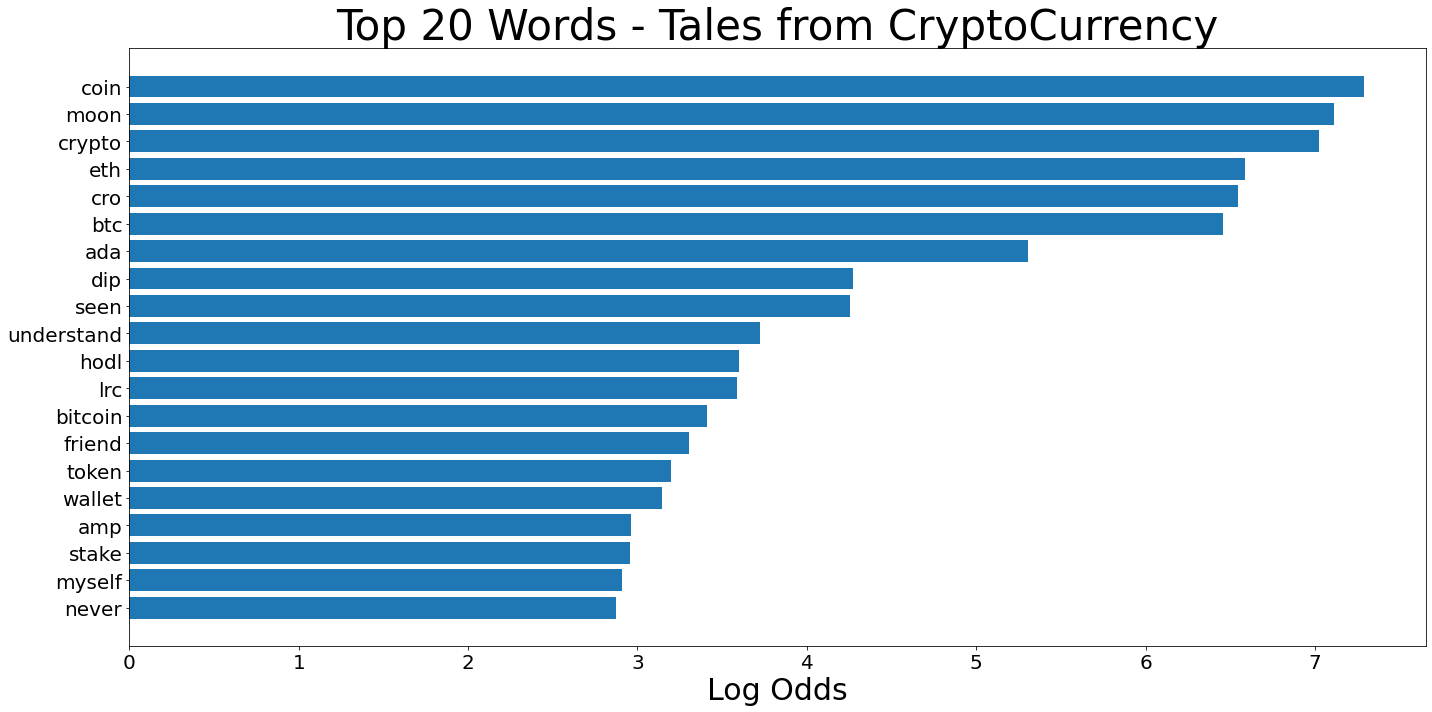

In [44]:
beta = gs.best_estimator_.named_steps['lr'].coef_

vocab = gs.best_estimator_.named_steps['cvec'].get_feature_names()

beta_df = pd.DataFrame( {'top_words': vocab, 'Beta' :beta[0]})
beta_df['log_odds'] = beta_df['Beta'].map(lambda x: np.exp(x))
beta_df = beta_df.set_index('top_words')
beta_df = beta_df.sort_values('log_odds',ascending = False)

weights = beta_df['log_odds'].head(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Log Odds', fontsize=30)
plt.title(f'Top 20 Words - Tales from CryptoCurrency', fontsize=42)
plt.tight_layout()

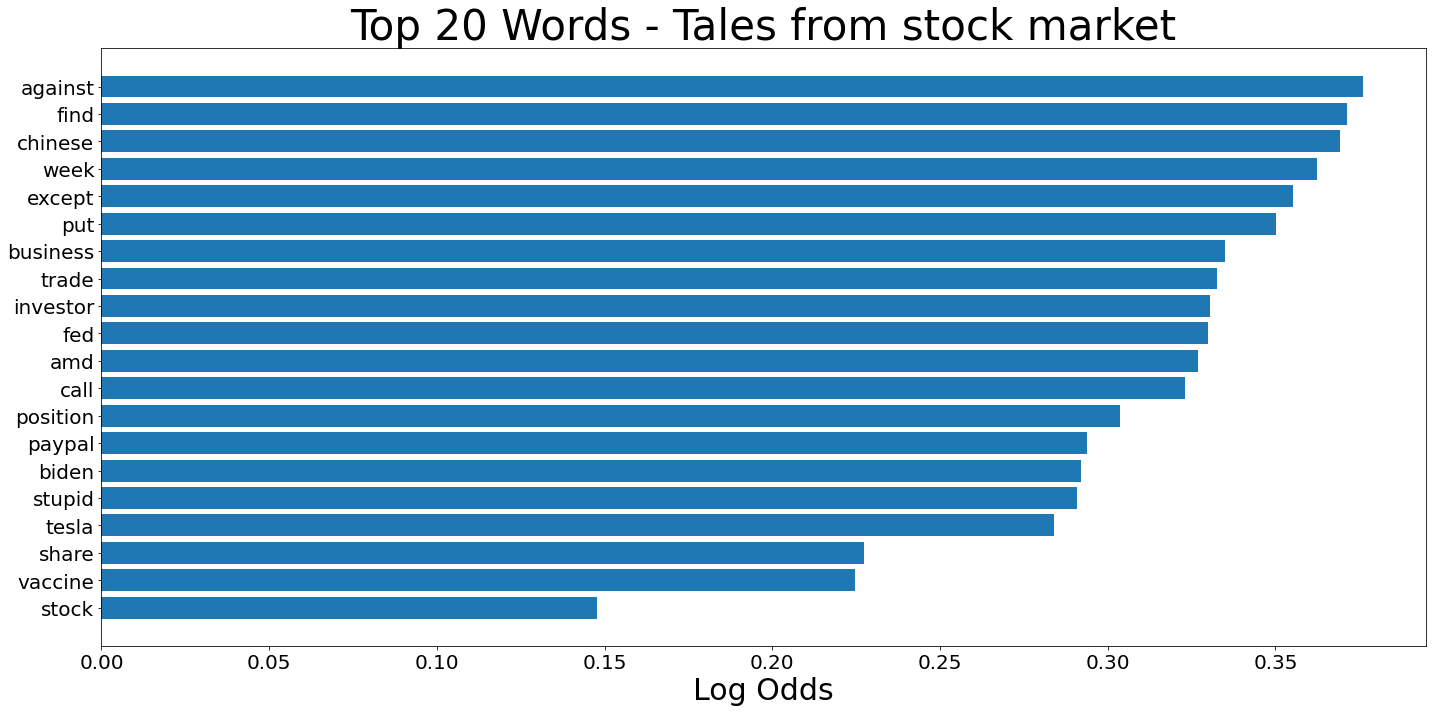

In [45]:
weights = beta_df['log_odds'].tail(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Log Odds', fontsize=30)
plt.title(f'Top 20 Words - Tales from stock market', fontsize=42)
plt.tight_layout()

In [46]:
#creating a confusion matrix

y_pred = gs.predict(X_test)
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,239,132
actual pos,82,355


### Model 2: CountVectorizer & Naive Bayes

In [47]:
# set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Naive Bayes (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000, 10,000, 15,000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features' : [5_000, 10_000, 15_000],
    'cvec__min_df' : [2,3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [48]:
# Fit GridSearch to training data.
gs.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000, 10000, 15000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [49]:
# What's the best score?
gs.best_score_

0.7149390815370197

In [50]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [51]:
# Save best model as gs_model.

gs_model = gs.best_estimator_

In [52]:
# Score model on training set.
print(f'Train score is {gs_model.score(X_train, y_train)}')
# Score model on testing set.
print(f'Test score is {gs_model.score(X_test, y_test)}')

Train score is 0.8502475247524752
Test score is 0.7227722772277227


In [53]:
y_pred = gs.predict(X_test)
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,248,123
actual pos,101,336


/Users/sileshihirpa/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


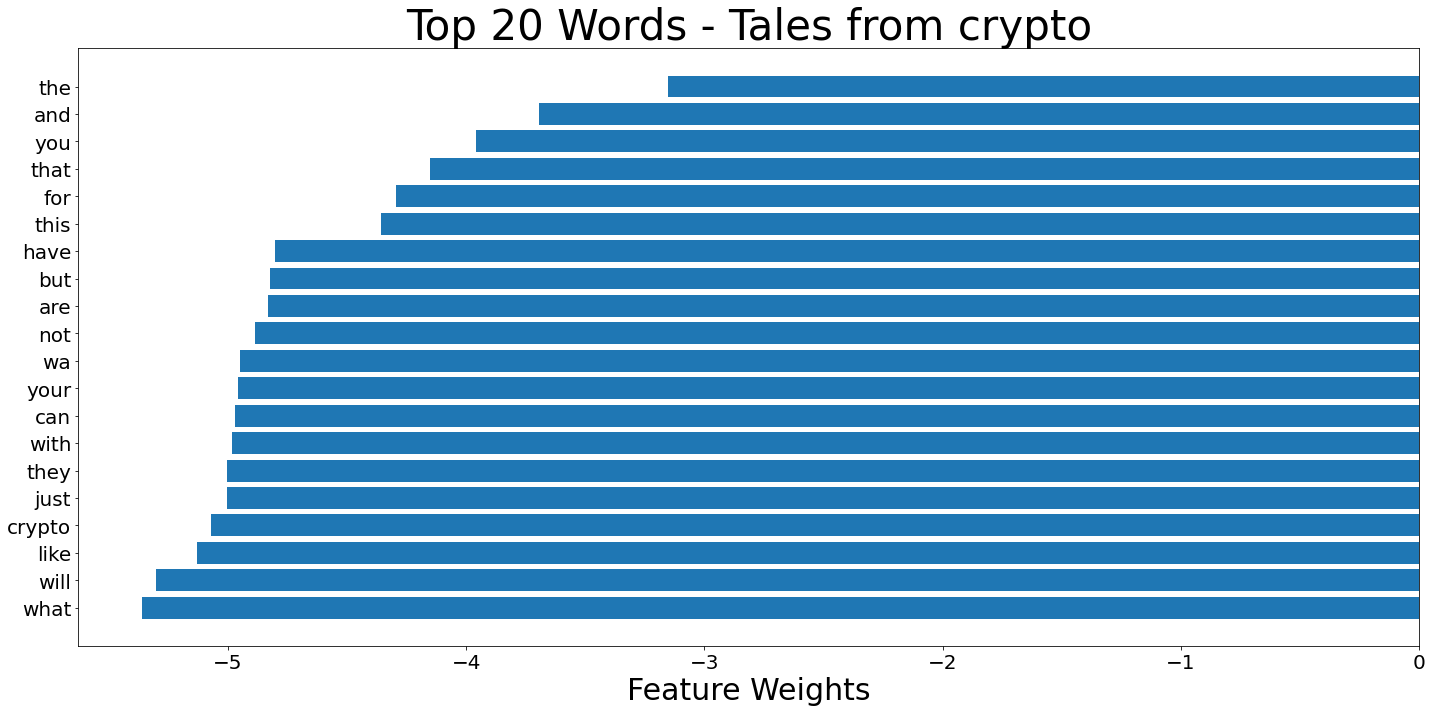

In [54]:
vocab = gs.best_estimator_.named_steps['cvec'].get_feature_names()

coef = list(gs.best_estimator_.named_steps['nb'].coef_[0])

feature_df = pd.DataFrame( {'top_words': vocab, 'importance': coef })

feature_df = feature_df.set_index('top_words')
feature_df = feature_df.sort_values('importance',ascending = False)

weights = feature_df['importance'].head(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Feature Weights', fontsize=30)
plt.title(f'Top 20 Words - Tales from crypto', fontsize=42)
plt.tight_layout()

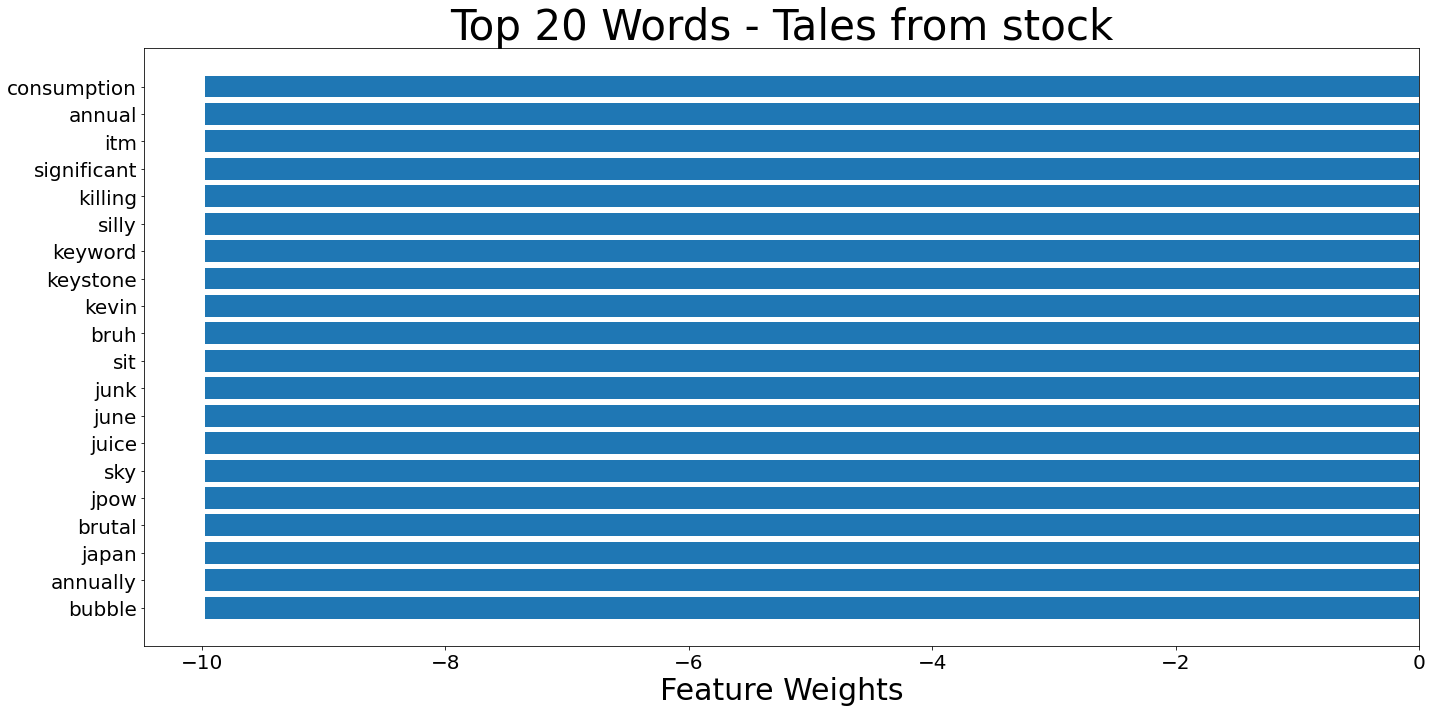

In [55]:
weights = feature_df['importance'].tail(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Feature Weights', fontsize=30)
plt.title(f'Top 20 Words - Tales from stock', fontsize=42)
plt.tight_layout()

## Model 3: TF - IDF Vectorizer & Logistic Regression

In [56]:
pipe2 = Pipeline([
                ('tf', TfidfVectorizer()),
                ('lr', LogisticRegression())
])

params2 = {
                'tf__max_features' : [5000,10_000,15_000],
                'tf__ngram_range' : [(1,1), (1,2)]
}

gs2 = GridSearchCV(pipe2, param_grid = params2, cv = 5)

In [57]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'tf__max_features': [5000, 10000, 15000],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [58]:
# What's the best score?
gs2.best_score_

0.7112217772855074

In [59]:
gs2.best_params_

{'tf__max_features': 5000, 'tf__ngram_range': (1, 1)}

In [60]:
# Save best model as gs_model.

gs_model = gs2.best_estimator_

In [61]:
# Score model on training set.
print(f'Train score is {gs_model.score(X_train, y_train)}')
# Score model on testing set.
print(f'Test score is {gs_model.score(X_test, y_test)}')

Train score is 0.9088283828382838
Test score is 0.7438118811881188


In [62]:
y_pred = gs2.predict(X_test)
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,238,133
actual pos,74,363


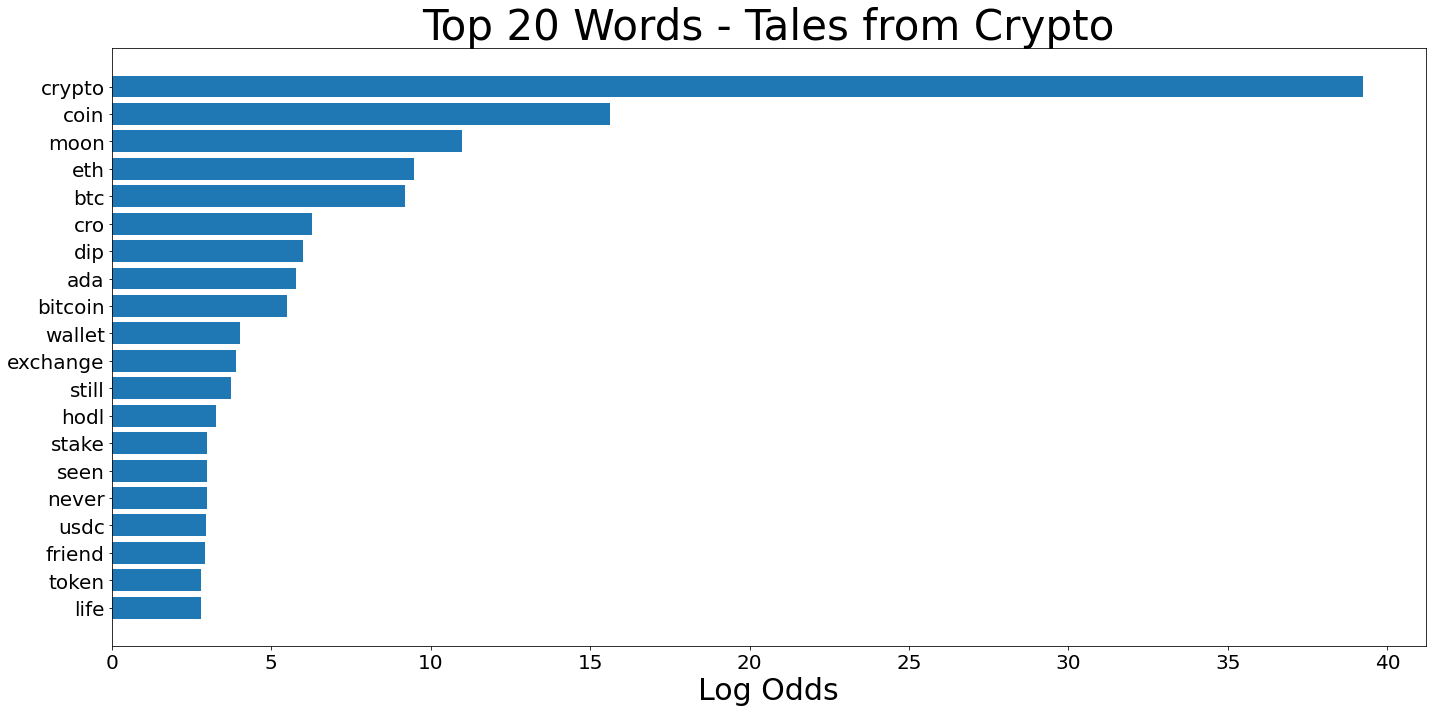

In [63]:
beta = gs2.best_estimator_.named_steps['lr'].coef_

vocab = gs2.best_estimator_.named_steps['tf'].get_feature_names()

beta_df = pd.DataFrame( {'top_words': vocab, 'Beta' :beta[0]})
beta_df['log_odds'] = beta_df['Beta'].map(lambda x: np.exp(x))
beta_df = beta_df.set_index('top_words')
beta_df = beta_df.sort_values('log_odds',ascending = False)

weights = beta_df['log_odds'].head(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Log Odds', fontsize=30)
plt.title(f'Top 20 Words - Tales from Crypto', fontsize=42)
plt.tight_layout()

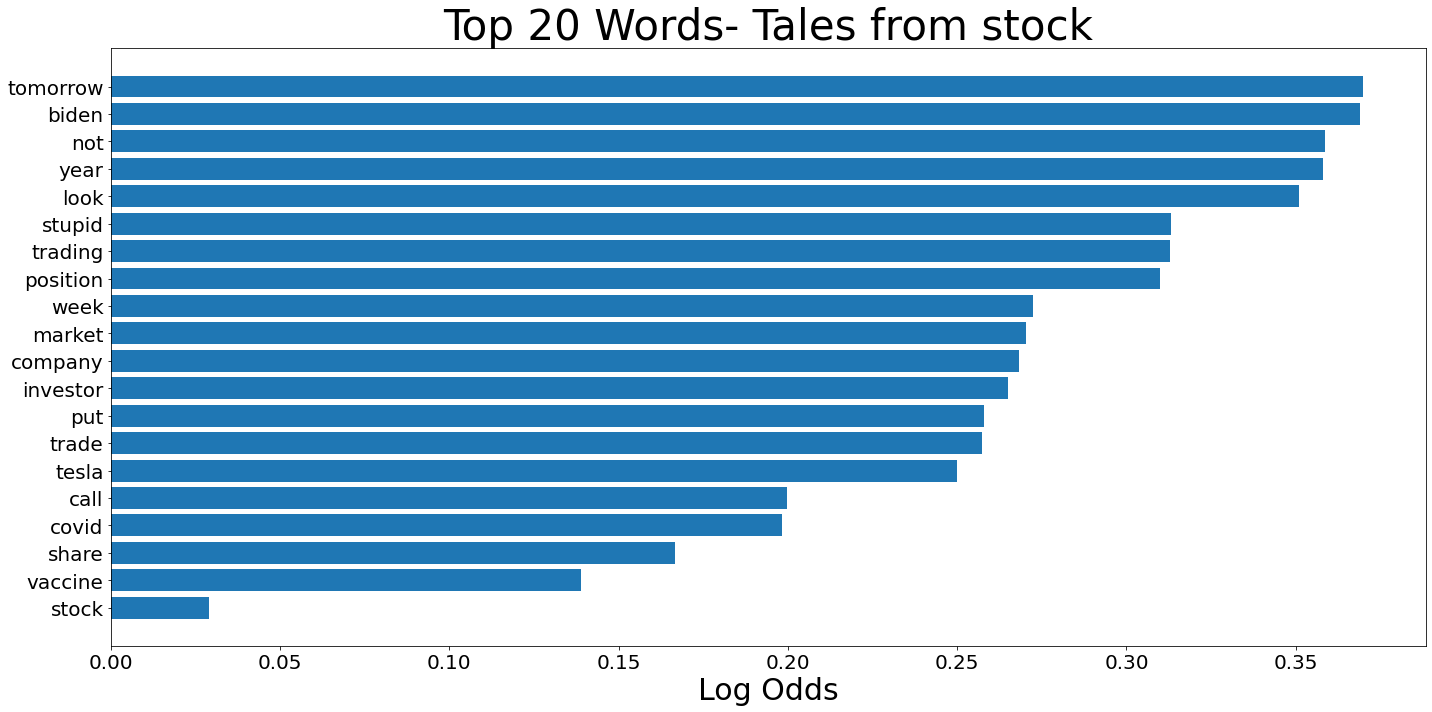

In [64]:
weights = beta_df['log_odds'].tail(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Log Odds', fontsize=30)
plt.title(f'Top 20 Words- Tales from stock', fontsize=42)
plt.tight_layout()

## Model 4: TF - IDF Vectorizer & Multinomial Naive Bayes

In [65]:
pipe2 = Pipeline([
                ('tf', TfidfVectorizer()),
                ('nb', MultinomialNB())
])

params2 = {
                'tf__max_features' : [5000,10_000,15_000],
                'tf__ngram_range' : [(1,1), (1,2)]
}

gs2 = GridSearchCV(pipe2, param_grid = params2, cv = 5)

In [66]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tf__max_features': [5000, 10000, 15000],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [67]:
gs2.best_params_

{'tf__max_features': 5000, 'tf__ngram_range': (1, 1)}

In [68]:
gs_train_accuracy = round(gs2.score(X_train, y_train),2)
print(f'Train Accuracy: {gs_train_accuracy}')

Train Accuracy: 0.92


In [69]:
gs_test_accuracy = round(gs2.score(X_test, y_test),2)
print(f'Test Accuracy: {gs_test_accuracy}')

Test Accuracy: 0.73


/Users/sileshihirpa/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


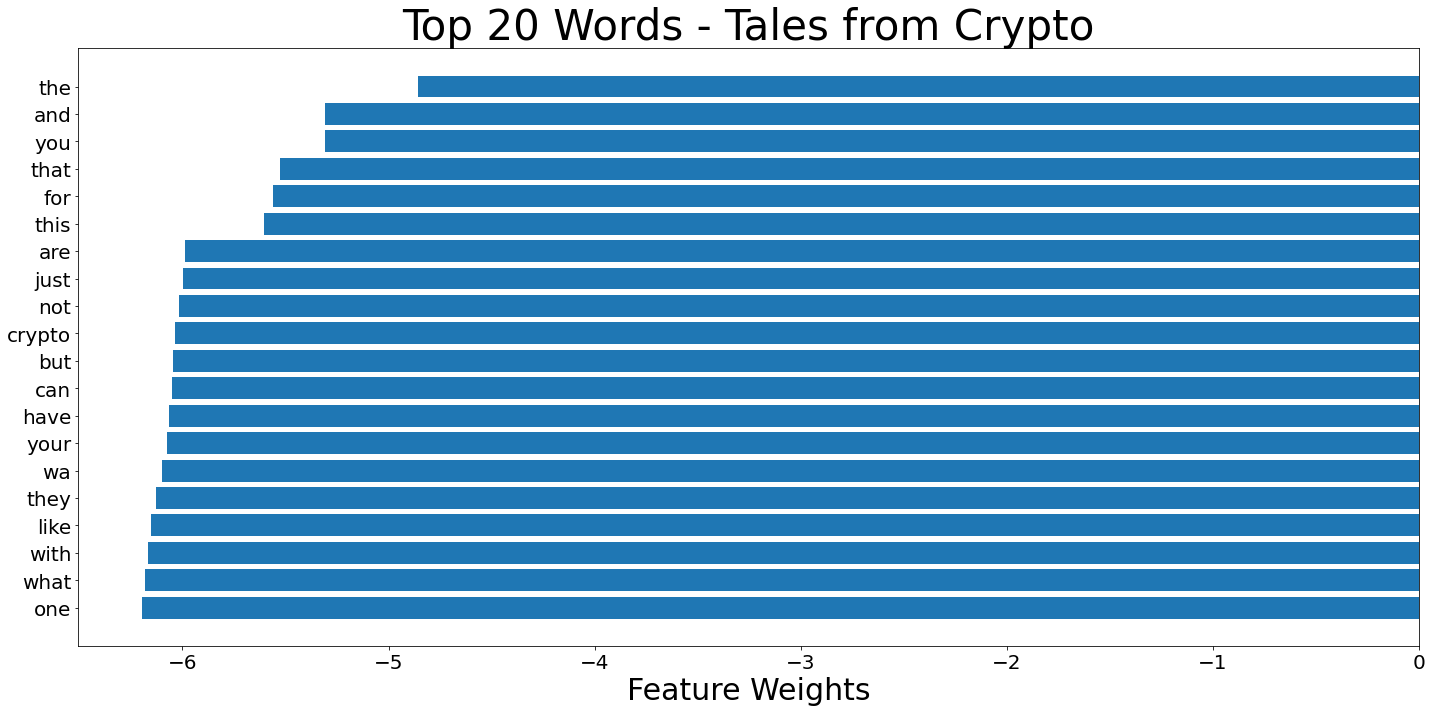

In [70]:
vocab = gs2.best_estimator_.named_steps['tf'].get_feature_names()

coef = list(gs2.best_estimator_.named_steps['nb'].coef_[0])

feature_df = pd.DataFrame( {'top_words': vocab, 'importance': coef })

feature_df = feature_df.set_index('top_words')
feature_df = feature_df.sort_values('importance',ascending = False)

weights = feature_df['importance'].head(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Feature Weights', fontsize=30)
plt.title(f'Top 20 Words - Tales from Crypto', fontsize=42)
plt.tight_layout()

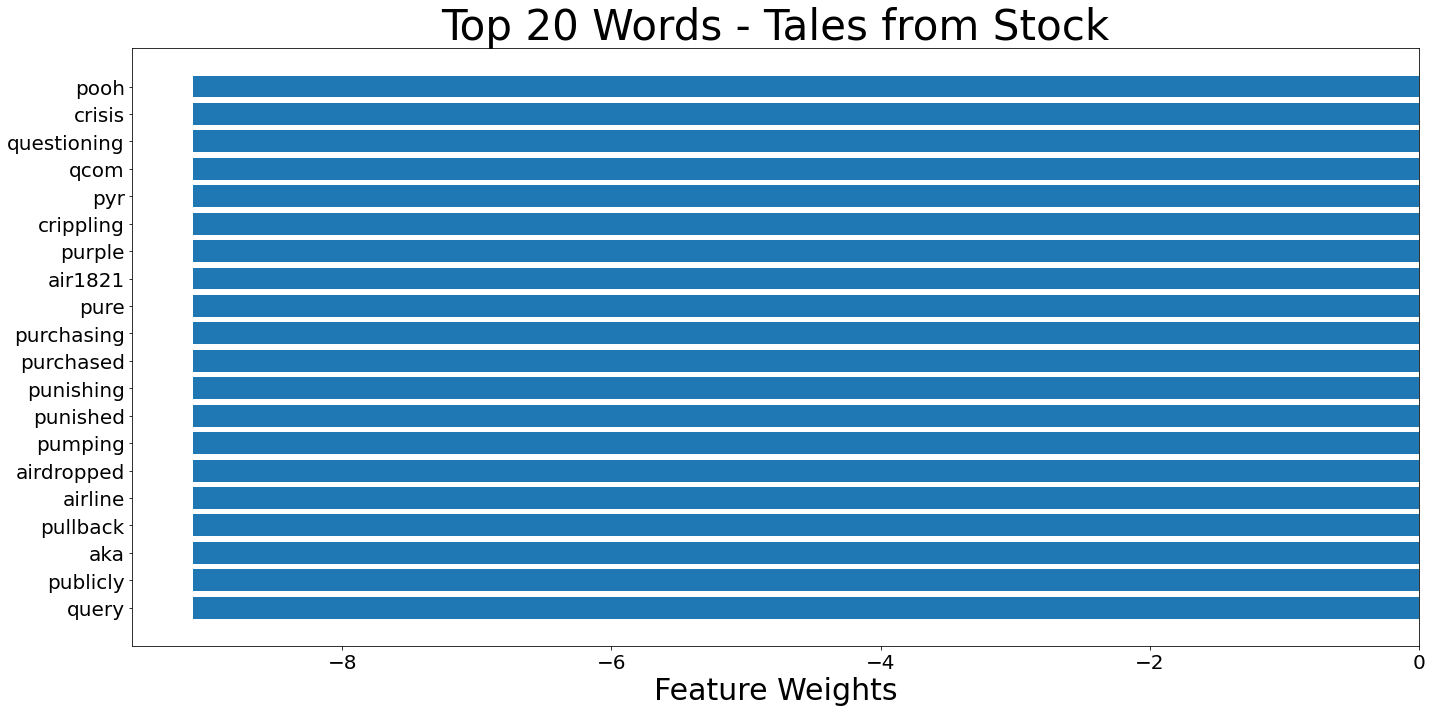

In [71]:
weights = feature_df['importance'].tail(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Feature Weights', fontsize=30)
plt.title(f'Top 20 Words - Tales from Stock', fontsize=42)
plt.tight_layout()

In [72]:
y_pred_2 = gs2.predict(X_test)

In [73]:
cm = confusion_matrix(y_test, y_pred_2)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])

In [74]:
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,217,154
actual pos,68,369



---


---

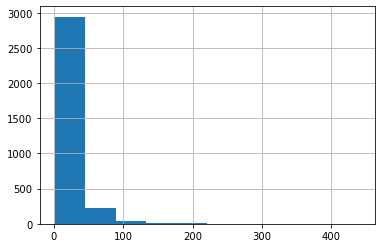

In [75]:
X.str.split(" ").str.len().hist();

In [76]:
cvec.get_feature_names()[1000:1010]

['case',
 'cash',
 'cashapp',
 'cashback',
 'cashed',
 'cashing',
 'cashless',
 'casino',
 'casuals',
 'cat']

In [77]:
X_train.shape

(2424,)

In [78]:
# Transform test
X_test = cvec.transform(X_test)

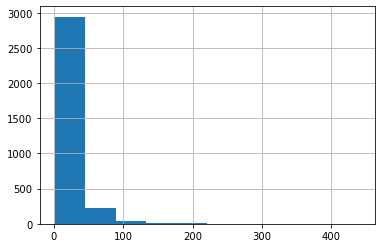

In [79]:
X.str.split(" ").str.len().hist();

In [80]:
#X_train.todense()

### edit stop words

In [81]:
# # Convert X_train into a DataFrame.
# X_train_df = pd.DataFrame(X_train.todense(), columns = cvec.get_feature_names())

# # plot top occuring words
# X_train_df.sum().sort_values(ascending=False).head(10).plot(kind = 'barh');

* All the top 10 words are stop words

In [82]:
# Let's look at sklearn's stopwords.
print(CountVectorizer(stop_words = 'english').get_stop_words())

frozenset({'found', 'many', 'though', 'something', 'back', 'so', 'fire', 'off', 'ourselves', 'thereupon', 'six', 'why', 'or', 'therein', 'was', 'their', 'along', 'hereby', 'who', 'whereby', 'further', 'neither', 'somewhere', 'fill', 'describe', 'each', 'on', 'cry', 'be', 'where', 'from', 'inc', 'those', 'mostly', 'forty', 'nothing', 'hundred', 'enough', 'once', 'next', 'everyone', 'side', 'wherein', 'you', 'two', 'before', 'three', 'hence', 'either', 'above', 'for', 'part', 'himself', 'what', 'after', 'others', 'up', 'twelve', 'almost', 'somehow', 'anyway', 'not', 'system', 'fifty', 'beside', 'together', 'yours', 'within', 'hereafter', 'anyone', 'anything', 'me', 'until', 'already', 'anywhere', 'he', 'still', 'even', 'due', 'against', 'and', 'thereafter', 'had', 'eight', 'themselves', 'across', 'his', 'throughout', 'formerly', 'amongst', 'around', 'become', 'indeed', 'made', 'thin', 'alone', 'into', 'could', 'least', 'behind', 'find', 'more', 'per', 'there', 'also', 'some', 'without', 

In [83]:
from sklearn.feature_extraction import text

text.ENGLISH_STOP_WORDS

add_stop_words = ['did', 'www', 'https', 'reddit', 'com', 'removed', 'don', 'doesn', 'getting', 'going', 'got', 'deleted', 'isn', 'removed']

stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [84]:
#stop_words

In [85]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [86]:
# baseline accuracy double-checking
y_train.value_counts(normalize = True)

1    0.541339
0    0.458661
Name: target, dtype: float64

- Majority (54%) of the document from the subreddit is about cryptocurrency

### explore feature importances and effect of stop words, n-grams

In [87]:
# using standard stop words = "english"

cvec = CountVectorizer(analyzer = "word",                        
                         tokenizer = None, 
                         preprocessor = None,
                         stop_words = "english", 
                         max_features = 10000)
lr = LogisticRegression()

pipe = Pipeline([
    ('cvec', cvec),
    ('lr', lr)
])

In [88]:
# baseline Logistic model

pipe.fit(X_train, y_train)
print('train score:', pipe.score(X_train, y_train))
print('test score:', pipe.score(X_test, y_test))

train score: 0.9551963048498845
test score: 0.7197750702905342


In [89]:
from sklearn.model_selection import train_test_split, cross_val_score



In [90]:
cross_val_score(pipe, X_train, y_train, cv=3)

array([0.71191136, 0.70637119, 0.69486824])

In [91]:
# Estimate how your model will perform on unseen data
cross_val_score(pipe, X_train, y_train, cv=3).mean() 

0.7043835956780043

In [92]:
# Training score
pipe.score(X_train, y_train)

0.9551963048498845

In [93]:

# Test score
pipe.score(X_test, y_test)

0.7197750702905342

In [94]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range':[(1, 1), (1, 2)]
}

In [95]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                 param_grid = pipe_params, # what parameters values are we searching?
                 cv = 5, # 5-fold cross-validation.
                 n_jobs = -1)

In [96]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(max_features=10000,
                                                        stop_words='english')),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [97]:
# What's the best score?
print(gs.best_score_)

0.7071593533487297


=> Accuracy of .707

In [98]:
# What are the best hyperparameters?
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [99]:
# Score model on training set.
gs.score(X_train, y_train)

0.9270207852193996

- very solid model, then :)

In [100]:
# Score model on testing set.
gs.score(X_test, y_test)

0.7328959700093721

- misclassification = 1 - accuracy

=> on the training set;

missclassification = 1 - 0.9254166666666667, say mtr, and on testing set,


missclassification = 1-0.7066779374471682, say mtt. 



In [101]:
mtr = 1 - 0.9254166666666667
mtr

0.07458333333333333

In [102]:
mtt = 1-0.7066779374471682
mtt

0.2933220625528318

* misclassification on testing data is 29.33% whereas on training it's only 7.46%

So, accuracy may not be the best score.

so, we gonna evaluate specificity and precision. Go all the way down.

------

---



In [103]:
lr_feat00 = pd.DataFrame(data=lr.coef_.T, index=cvec.get_feature_names())
lr_feat00.columns = ['coef_']
lr_feat00['abs_coef'] = np.abs(lr_feat00['coef_'])
lr_feat00.sort_values(by='abs_coef', ascending=False).head(30)

,coef_,abs_coef
crypto,2.107617,2.107617
coin,1.990010,1.990010
stock,-1.958336,1.958336
moon,1.927906,1.927906
eth,1.759028,1.759028
btc,1.737258,1.737258
ada,1.588372,1.588372
cro,1.526815,1.526815
vaccine,-1.491925,1.491925
dip,1.410695,1.410695


In [104]:
# using additional stop words

cvec = CountVectorizer(analyzer = "word",                        
                         tokenizer = None, 
                         preprocessor = None,
                         stop_words = stop_words, 
                         max_features = 10000)
lr = LogisticRegression()

pipe = Pipeline([
    ('cvec', cvec),
    ('lr', lr)
])

In [105]:
# baseline Logistic model

pipe.fit(X_train, y_train)
print('train score:', pipe.score(X_train, y_train))
print('test score:', pipe.score(X_test, y_test))

train score: 0.9556581986143187
test score: 0.7235238987816307


In [106]:
lr_feat01 = pd.DataFrame(data=lr.coef_.T, index=cvec.get_feature_names())
lr_feat01.columns = ['coef_']
lr_feat01.sort_values(by='coef_', ascending=False).head(30)

,coef_
crypto,2.099024
coin,1.971163
moon,1.925185
eth,1.770181
btc,1.741445
ada,1.586577
cro,1.537964
dip,1.439132
bitcoin,1.282066
hodl,1.229309


In [107]:
# Random forest model

In [108]:
# using standard stop words = "english"

cvec = CountVectorizer(analyzer = "word",                        
                         tokenizer = None, 
                         preprocessor = None,
                         stop_words = "english", 
                         max_features = 10000)
rf = RandomForestClassifier(random_state = 42)

pipe = Pipeline([
    ('cvec', cvec),
    ('rf', rf)
])

pipe.fit(X_train, y_train)
print('train score:', pipe.score(X_train, y_train))
print('test score:', pipe.score(X_test, y_test))

train score: 0.9916859122401848
test score: 0.7029053420805998


In [109]:
rf_feat = cvec.get_feature_names()
rf_feat_imp = rf.feature_importances_

df_rf_feat00 = pd.DataFrame(data=rf_feat_imp, index=rf_feat)

In [110]:
df_rf_feat00.sort_values(by=0, ascending=False).head(30)

,0
stock,0.018600
crypto,0.016149
coin,0.011184
btc,0.007780
moon,0.007344
vaccine,0.006878
eth,0.006794
covid,0.005870
market,0.005344
year,0.004451


In [111]:
df_rf_feat00.sort_values(by=0, ascending=False).tail(20)

,0
c19,0.0
intercom,0.0
cam,0.0
inherit,0.0
sickness,0.0
innovate,0.0
signed,0.0
contrasted,0.0
signaling,0.0
insight,0.0


In [112]:
# using additional stop words

cvec = CountVectorizer(analyzer = "word",                        
                         tokenizer = None, 
                         preprocessor = None,
                         stop_words = stop_words, 
                         max_features = 10000)
rf = RandomForestClassifier(random_state = 42)

pipe = Pipeline([
    ('cvec', cvec),
    ('rf', rf)
])

pipe.fit(X_train, y_train)
print('train score:', pipe.score(X_train, y_train))
print('test score:', pipe.score(X_test, y_test))

train score: 0.9903002309468822
test score: 0.711340206185567


In [113]:
rf_feat = cvec.get_feature_names()
rf_feat_imp = rf.feature_importances_

df_rf_feat01 = pd.DataFrame(data=rf_feat_imp, index=rf_feat)

df_rf_feat01.columns = ['feature_importances_']

In [114]:
df_rf_feat01.sort_values(by='feature_importances_', ascending=False).head(30)

,feature_importances_
stock,0.020172
crypto,0.018810
coin,0.011784
moon,0.007937
vaccine,0.007835
btc,0.007282
covid,0.007156
eth,0.006260
market,0.004892
trade,0.004745


In [115]:
df_rf_feat01.sort_values(by='feature_importances_', ascending=False).tail(20)

,feature_importances_
absence,0.0
drilling,0.0
avg,0.0
litigation,0.0
proposed,0.0
sushi,0.0
lightning,0.0
deposit,0.0
liquidation,0.0
ability,0.0


## n-grams

In [116]:
# CountVectorizer & Logistic regression using additional stop words and 1 - 3 n-grams

cvec = CountVectorizer(analyzer = "word", 
                       tokenizer = None, 
                       preprocessor = None,
                       stop_words = stop_words, 
                       max_features = 10000, 
                       ngram_range = (1, 3)
                      )

lr = LogisticRegression()

pipe = Pipeline([
    ('cvec', cvec),
    ('lr', lr)
])

pipe.fit(X_train, y_train)
print('train score:', pipe.score(X_train, y_train))
print('test score:', pipe.score(X_test, y_test))

train score: 0.9464203233256351
test score: 0.7188378631677601


In [117]:
lr_feat03 = pd.DataFrame(data=lr.coef_.T, index=cvec.get_feature_names())
lr_feat03.columns = ['coef_']
lr_feat03['abs_coef'] = np.abs(lr_feat03['coef_'])
lr_feat03.sort_values(by='abs_coef', ascending=False).head(50)

,coef_,abs_coef
crypto,2.070159,2.070159
stock,-1.881382,1.881382
coin,1.861472,1.861472
moon,1.839987,1.839987
eth,1.726386,1.726386
btc,1.663653,1.663653
ada,1.539839,1.539839
cro,1.503034,1.503034
vaccine,-1.355576,1.355576
dip,1.336287,1.336287


In [118]:
lr_feat03.sort_values(by='abs_coef', ascending=False).tail(30)

,coef_,abs_coef
microsoft think long,-1.267770e-05,1.267770e-05
microsoft think,-1.267770e-05,1.267770e-05
remember investing,-1.267770e-05,1.267770e-05
remember investing small,-1.267770e-05,1.267770e-05
overpriced expect correction,-1.267770e-05,1.267770e-05
make decent return,-1.267770e-05,1.267770e-05
return day,-1.267770e-05,1.267770e-05
overpriced expect,-1.267770e-05,1.267770e-05
man crapping started,-1.267770e-05,1.267770e-05
make sense technically,-1.267770e-05,1.267770e-05


In [119]:
# tf-idf & Logistic regression using additional stop words and 1 - 3 n-grams

tf = TfidfVectorizer(analyzer = "word", 
                     stop_words = stop_words, 
                     max_features = 10000, 
                     ngram_range = (1, 3))

lr = LogisticRegression()

pipe = Pipeline([
    ('tf', tf),
    ('lr', lr)
])

pipe.fit(X_train, y_train)
print('train score:', pipe.score(X_train, y_train))
print('test score:', pipe.score(X_test, y_test))

train score: 0.9321016166281755
test score: 0.7272727272727273


In [120]:
lr_tf_feat01 = pd.DataFrame(data=lr.coef_.T, index=cvec.get_feature_names())
lr_tf_feat01.columns = ['coef_']
lr_tf_feat01['abs_coef'] = np.abs(lr_tf_feat01['coef_'])
lr_tf_feat01.sort_values(by='abs_coef', ascending=False).head(50)

,coef_,abs_coef
crypto,3.386391,3.386391
stock,-3.196134,3.196134
coin,2.271453,2.271453
moon,2.142370,2.142370
btc,2.094718,2.094718
eth,2.067259,2.067259
vaccine,-1.884849,1.884849
ada,1.601872,1.601872
dip,1.587393,1.587393
cro,1.579008,1.579008


In [121]:
lr_tf_feat01.sort_values(by='abs_coef', ascending=False).tail(30)

,coef_,abs_coef
date,0.002603,0.002603
pattern,0.002486,0.002486
release,0.002289,0.002289
past year,-0.001988,0.001988
utm,-0.001972,0.001972
apputm,-0.001972,0.001972
simply,-0.001965,0.001965
overall,0.001920,0.001920
winter,0.001917,0.001917
aid,-0.001867,0.001867


In [122]:
# CountVectorizer & Random forest using additional stop words and 1 - 3 n-grams

cvec = CountVectorizer(analyzer = "word", 
                       tokenizer = None, 
                       preprocessor = None,
                       stop_words = stop_words, 
                       max_features = 10000, 
                       ngram_range = (1, 3)
                      )
rf = RandomForestClassifier(random_state = 42)

pipe = Pipeline([
    ('cvec', cvec),
    ('rf', rf)
])

pipe.fit(X_train, y_train)
print('train score:', pipe.score(X_train, y_train))
print('test score:', pipe.score(X_test, y_test))

train score: 0.9782909930715935
test score: 0.6982193064667291


In [123]:
rf_feat = cvec.get_feature_names()
rf_feat_imp = rf.feature_importances_

df_rf_feat02 = pd.DataFrame(data=rf_feat_imp, index=rf_feat)

df_rf_feat02.columns = ['feature_importances_']

In [124]:
df_rf_feat02.sort_values(by='feature_importances_', ascending=False).head(50)

,feature_importances_
stock,0.019251
crypto,0.015070
coin,0.010046
moon,0.008067
btc,0.007908
vaccine,0.007093
eth,0.006425
covid,0.005358
market,0.004406
trade,0.004305


In [125]:
df_rf_feat02.sort_values(by='feature_importances_', ascending=False).tail(20)

,feature_importances_
possible liquidity tether,0.0
possible outcome,0.0
possible tough,0.0
possible yes yes,0.0
post ha link,0.0
collapsed,0.0
possibly 100,0.0
possibly bigger,0.0
possibly bigger ev,0.0
possibly create,0.0


## CountVectorizer vs Tf-idf

In [126]:
# tfidf using "english" stop words, 1-grams

tf = TfidfVectorizer(analyzer = "word", 
                     stop_words = "english", 
                     max_features = 10000, 
                     ngram_range = (1, 1))

lr = LogisticRegression()

pipe = Pipeline([
    ('tf', tf),
    ('lr', lr)
])

In [127]:
# baseline Logistic model

pipe.fit(X_train, y_train)
print('train score:', pipe.score(X_train, y_train))
print('test score:', pipe.score(X_test, y_test))

train score: 0.9311778290993071
test score: 0.7300843486410497


In [128]:
lr_tf_feat00.sort_values(by='abs_coef', ascending=False).tail(10)

NameError: name 'lr_tf_feat00' is not defined

In [ ]:
# using additional stop words

tf = TfidfVectorizer(analyzer = "word", 
                     stop_words = stop_words, 
                     max_features = 10000, 
                     ngram_range = (1, 1))

lr = LogisticRegression()

pipe = Pipeline([
    ('tf', tf),
    ('lr', lr)
])

In [ ]:
# baseline Logistic model

pipe.fit(X_train, y_train)
print('train score:', pipe.score(X_train, y_train))
print('test score:', pipe.score(X_test, y_test))

In [ ]:
lr_tf_feat01 = pd.DataFrame(data=lr.coef_.T, index=cvec.get_feature_names())
lr_tf_feat01.columns = ['coef_']
lr_feat00['abs_coef'] = np.abs(lr_feat00['coef_'])
lr_tf_feat01.sort_values(by='coef_', ascending=False).head(10)

In [ ]:
lr_tf_feat01.sort_values(by='coef_', ascending=False).tail(10)

## Logistic regression model

#### baseline

In [ ]:
# set up pipeline

# initialize
cvec = CountVectorizer(stop_words = stop_words)
lr = LogisticRegression()

pipe = Pipeline([
    ('cvec', cvec),
    ('lr', lr)
])

In [ ]:
# baseline Logistic model

pipe.fit(X_train, y_train)
print('train score:', pipe.score(X_train, y_train))
print('test score:', pipe.score(X_test, y_test))


## gridsearch

In [ ]:
#%%time

# gridsearchCV tests cross-validation for the parameters
# pipe

params = {
#     'cvec__stop_words': [stop_words], 
    'cvec__max_features': [5000, 10000, 20000], 
#     'cvec__ngram_range': [(1, 1), (1, 2)], 
    'lr__penalty': ['l1', 'l2'], 
    'lr__C': np.logspace(-10, 0, 10)
}
gs = GridSearchCV(pipe, param_grid=params, cv=3, verbose=1)
gs.fit(X_train, y_train)

In [ ]:
print('gs.best_score_', gs.best_score_)
print('gs.best_params_', gs.best_params_)
print('gs.score(X_test, y_test)', gs.score(X_test, y_test))

## Random forest model
#### baseline

In [ ]:
# set up pipeline

# initialize
cvec = CountVectorizer(analyzer = "word",                        
                         tokenizer = None, 
                         preprocessor = None,
                         stop_words = stop_words, 
                         max_features = 10000)
rf = RandomForestClassifier(random_state = 42)

pipe = Pipeline([
    ('cvec', cvec),
    ('rf', rf)
])

In [ ]:
# baseline Random forest

pipe.fit(X_train, y_train)
print('train score:', pipe.score(X_train, y_train))
print('test score:', pipe.score(X_test, y_test))

### gridsearch

In [ ]:
# gridsearchCV tests cross-validation for the parameters
# pipe

params = {
#     'cvec__stop_words': [None, 'english'], 
    'cvec__max_features': [5000, 10000, 20000], 
    'cvec__ngram_range': [(1, 1), (1, 2)], 
    'rf__n_estimators': [10, 20, 30],
    'rf__max_depth': [None, 10, 20]
}

gs = GridSearchCV(pipe, param_grid=params, cv=3, verbose=1)
gs.fit(X_train, y_train)

In [ ]:
print('gs.best_score_', gs.best_score_)
print('gs.best_params_', gs.best_params_)
print('gs.score(X_test, y_test)', gs.score(X_test, y_test))

## Sentiment Analysis

In [ ]:
# Define a function that accepts text and returns the polarity.
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [ ]:
# Create a new DataFrame column for sentiment 
df['sentiment'] = df.body.apply(detect_sentiment)

---

----

In [ ]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [ ]:
# View confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap = 'Blues', values_format = 'd');

In [ ]:
print(tn, fp, fn, tp)

In [ ]:
 # Calculate the specificity (TRUE NEG RATE)
spec = tn / (tn + fp)

print('Specificity:', spec)

In [ ]:
# Calculate precision

precision = tp / (tp + fp)

print('Precision: ', precision)

## Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer


#### Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer


In [ ]:
# Instantiate the transformer.
tvec = TfidfVectorizer()

In [ ]:
#Let's visualize the top words.
# convert training data to dataframe
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(),
                         columns = tvec.get_feature_names())

# plot top occuring words
X_train_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh');

## Modeling Using the TfidfVectorizer

In [ ]:
# Let's set a pipeline up with two stages:
# 1. tf-idf vectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [ ]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params = {
    'tvec__max_features': [2000, 3000, 4000, 5000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)]
}

In [ ]:
# Instantiate GridSearchCV.

gs_tvec = GridSearchCV(pipe_tvec, # What are we optimizing?
                      param_grid = pipe_tvec_params, # What parameter values are we searching?
                      cv = 5, #5-fold cross-validation
                      n_jobs = -1)


In [ ]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

In [ ]:
# Best parameters
gs_tvec.best_params_

In [ ]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

In [ ]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

In [ ]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

# Calculate the specificity and precision

spec = tn / (tn + fp)
prec = tp / (tp + fp)

print('Specificity:', spec)
print('Precision:', prec)

In [ ]:
# visualize confusion matrix

plot_confusion_matrix(gs_tvec, X_test, y_test, cmap = 'Blues', values_format = 'd');